In [3]:
import os
import re
from typing import List, Tuple, Dict

import pandas as pd
import numpy as np

from konlpy.tag import Mecab
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from dotenv import load_dotenv

load_dotenv()
mecab = Mecab(os.environ['MECAB_DIC_PATH'])

In [31]:
df = pd.read_csv('./data/link_data.csv').fillna('')
unique_pik = df.pik_id.unique()

pik_to_index = {pik_id: idx for idx, pik_id in enumerate(unique_pik)}
pik_to_num = {row[0]: row[1][0] for row in df.groupby(['pik_id']).count().iterrows()}
pik_to_title = {row[0][0]: row[0][1] for row in df.groupby(['pik_id', 'pik_title']).count().iterrows()}

index_to_pik = {idx: pik_id for idx, pik_id in enumerate(unique_pik)}

In [28]:
def preprocess(text: str):
    
    result = re.sub(pattern=r'[\[\]():|]', repl='', string=text)
    result = re.sub(pattern=r'\s', repl=' ', string=result)
    result = re.sub(pattern=r'[一-龥]', repl='', string=result)
    result = re.sub(pattern=r'[ㄱ-ㅎㅏ-ㅣ]', repl=' ', string=result)

    result.strip()
    result = ' '.join(result.split())

    return result

In [29]:
def extract_noun(tokenizer: Mecab, text: str, target_pos=['NNG', 'NNP', 'NNB']) -> List[str]:
    pos_list : List[Tuple[str, str]] = tokenizer.pos(preprocess(text))
    result = [p[0] for p in pos_list if p[1] in target_pos]

    return result

In [7]:
tfidf_vectorizer_pik = TfidfVectorizer(tokenizer=lambda x: extract_noun(mecab, x), min_df=2, max_features=500)
tfidf_vectorizer_category = TfidfVectorizer(tokenizer=lambda x: extract_noun(mecab, x), min_df=2, max_features=500)
tfidf_vectorizer_link = TfidfVectorizer(tokenizer=lambda x: extract_noun(mecab, x), min_df=2, max_features=500)
# count_vectorizer = CountVectorizer(tokenizer=lambda x: extract_noun(mecab, x), min_df=2, max_features=5000)

In [8]:
vec_pik = tfidf_vectorizer_pik.fit_transform(df.pik_title)
vec_category = tfidf_vectorizer_category.fit_transform(df.category_title)
vec_memo = tfidf_vectorizer_link.fit_transform(df.memo)

## K-Means Clustering

In [9]:
concat_matrix = np.concatenate((vec_pik.toarray(), vec_category.toarray(), vec_memo.toarray()), axis=1)
concat_matrix.shape

(43775, 1500)

In [10]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [11]:
Kmeans = KMeans(n_clusters=13)
Kmeans.fit(concat_matrix)

KMeans(n_clusters=13)

In [52]:
labels = Kmeans.predict(concat_matrix)

In [35]:
def extract_data_by_label(target_label: int, labels: List[int]) -> pd.DataFrame:
    target_ids = [idx for idx, label in enumerate(labels) if label == target_label]
    return df.loc[target_ids]

def extract_statics_by_label(target_label: int, labels: List[int]) -> Dict[int, int]:
    target_ids = [idx for idx, label in enumerate(labels) if label == target_label]
    target_df = df.loc[target_ids]
    grouped = target_df.groupby(['pik_id']).count()

    return {row[0]: row[1][0] for row in grouped.iterrows()}

def convert_ratio(target_dict: Dict[int, int]) -> Dict[int, Dict[str, float]]:
    result = {pik_id: {'title': pik_to_title[pik_id], 'ratio': num / pik_to_num[pik_id]} for pik_id, num in target_dict.items()}
    return result

In [44]:
d= extract_statics_by_label(7, labels)
convert_ratio(d)

{3085: {'title': 'SNS 마케팅, 이거 하나로 끝내기', 'ratio': 0.3333333333333333},
 3511: {'title': 'SNS 마케팅, 이거 하나로 끝내기', 'ratio': 0.3333333333333333},
 3543: {'title': 'SNS 마케팅, 이거 하나로 끝내기', 'ratio': 0.3333333333333333},
 3573: {'title': 'SNS 마케팅, 이거 하나로 끝내기', 'ratio': 0.3333333333333333},
 3592: {'title': 'SNS 마케팅, 이거 하나로 끝내기', 'ratio': 0.3333333333333333},
 3600: {'title': 'SNS 마케팅, 이거 하나로 끝내기', 'ratio': 0.5},
 3608: {'title': 'SNS 마케팅, 이거 하나로 끝내기', 'ratio': 0.3333333333333333},
 3614: {'title': 'SNS 마케팅, 이거 하나로 끝내기', 'ratio': 0.3333333333333333},
 3615: {'title': 'SNS 마케팅, 이거 하나로 끝내기', 'ratio': 0.3333333333333333},
 3616: {'title': '유용한 정보는 여기에 다 있다', 'ratio': 0.42857142857142855},
 3619: {'title': 'SNS 마케팅, 이거 하나로 끝내기', 'ratio': 0.5},
 3621: {'title': 'SNS 마케팅, 이거 하나로 끝내기', 'ratio': 0.3333333333333333},
 3626: {'title': 'SNS 마케팅, 이거 하나로 끝내기', 'ratio': 0.3333333333333333},
 3628: {'title': 'SNS 마케팅, 이거 하나로 끝내기', 'ratio': 0.3333333333333333},
 3633: {'title': 'SNS 마케팅, 이거 하나로 끝내기', 'ratio': 0.3

In [107]:
import random
from matplotlib import colors as mcolors


colors = mcolors.TABLEAU_COLORS
by_hsv = {name: mcolors.to_rgba(np.append(mcolors.rgb_to_hsv(mcolors.to_rgba(color)[:3]), .4))
                for name, color in colors.items()}

color_names = list(by_hsv.keys())
random.shuffle(color_names)

In [108]:
len(color_names)

10

## T-SNE

In [49]:
tsne = TSNE(random_state = 42)
# TSNE에는 transform 메서드가 없으므로 대신 fit_transform을 사용한다.
link_tsne = tsne.fit_transform(concat_matrix)

/home/jerry/anaconda3/envs/tokenizer/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/jerry/anaconda3/envs/tokenizer/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


/home/jerry/anaconda3/envs/tokenizer/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.


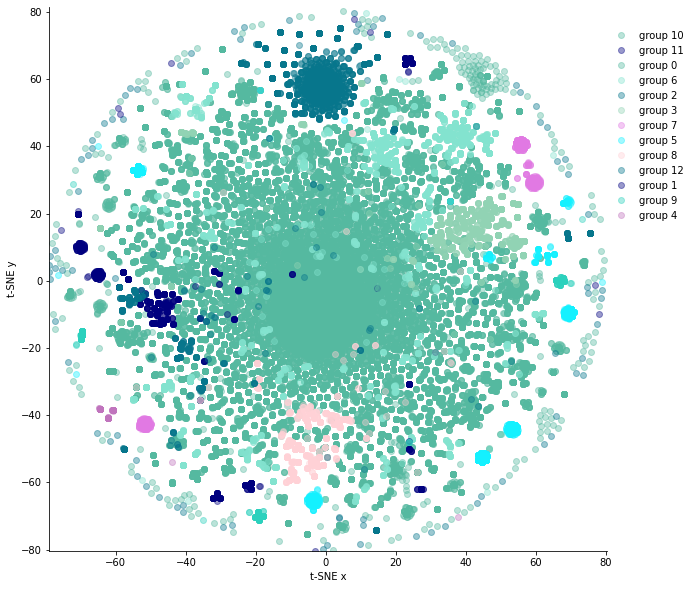

In [109]:
plt.figure(figsize=(10,10))
plt.xlim(link_tsne[:,0].min(), link_tsne[:,0].max()+1)
plt.ylim(link_tsne[:,1].min(), link_tsne[:,1].max()+1)

tsne_point_by_label = dict()

for i in range(len(concat_matrix)):
    label = labels[i]
    try:
        tsne_point_by_label[label]['x'].append(link_tsne[i, 0])
        tsne_point_by_label[label]['y'].append(link_tsne[i, 1])
    except KeyError:
        tmp_dict = {'x': [link_tsne[i, 0]], 'y': [link_tsne[i, 1]]}
        tsne_point_by_label[label] = tmp_dict


for label, coordinates in tsne_point_by_label.items():
    plt.plot(coordinates['x'], coordinates['y'], 'ro', color=by_hsv[color_names[label % 10]], label=f'group {label}')
    
plt.xlabel("t-SNE x")
plt.ylabel("t-SNE y")

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.legend(loc=(1.0, .6), frameon=False)